Data Preprocessing

In [1]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import gradio as gr
import re
import torch
from transformers import BertTokenizer, BertModel
from sklearn.preprocessing import LabelEncoder

# Dataset (keeping the same small dataset)
data = [
    ("أنا مخنوق ومش قادر أتنفس", "Distressed"),
    ("حاسس بضيق شديد ومش لاقي أي أمل", "Distressed"),
    ("كل حاجة حواليه سودا ومش عارف أعمل إيه", "Distressed"),
    ("حاسس بوحدة وكآبة كبيرة", "Distressed"),
    ("مش قادر أنام من كتر التفكير", "Distressed"),
    ("مش عارف أواجه الناس ولا أواجه نفسي", "Distressed"),
    ("حاسس بضياع ومفيش حد يساعدني", "Distressed"),
    ("الضغط النفسي مش مخليني أركز في حاجة", "Distressed"),
    ("حاسس إن الحياة مالهاش معنى", "Distressed"),
    ("كل حاجة بتسوء ومفيش حل", "Distressed"),
    ("أنا قلقان جدًا بسبب الامتحان", "Distressed"),
    ("حاسس إني قرفان ومش قادر أعمل حاجة", "Distressed"),
    # Non-Distressed examples
    ("أنا كويس النهارده", "Non-Distressed"),
    ("يوم عادي ومفيش حاجة تقلق", "Non-Distressed"),
    ("كل حاجة تمام والحمد لله", "Non-Distressed"),
    ("الأمور ماشية كويس الحمد لله", "Non-Distressed"),
    ("الجو جميل النهارده", "Non-Distressed"),
    ("مبسوط إن خطتي نجحت", "Non-Distressed"),
    ("النهارده قعدت مع صحابي واتونسنا", "Non-Distressed"),
    ("خلصت شغلي بدري وروحت أريح", "Non-Distressed"),
    ("بستمتع بوقتي وبعمل الحاجات اللي بحبها", "Non-Distressed"),
    ("حاسس بالراحة بعد فترة طويلة من الضغط", "Non-Distressed"),
]

# Preprocessing Function (for normalization)
def preprocess(text):
    text = re.sub(r"[إأآا]", "ا", text)  # Normalize Alif
    text = re.sub(r"ى", "ي", text)       # Normalize Alif Maksura to Ya
    text = re.sub(r"ؤ", "و", text)       # Normalize Waw with Hamza
    text = re.sub(r"ة", "ه", text)       # Normalize Teh Marbuta to Ha
    text = re.sub(r"[^\w\s]", "", text)  # Remove punctuation
    text = re.sub(r"\s+", " ", text).strip()  # Remove extra spaces
    return text




Model training


In [2]:
# Load Arabic BERT Tokenizer and Model
tokenizer = BertTokenizer.from_pretrained('asafaya/bert-base-arabic')
model = BertModel.from_pretrained('asafaya/bert-base-arabic')

# Function to get embeddings from BERT
def get_bert_embeddings(texts):
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt", max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1)  # Pooling the token embeddings
    return embeddings.numpy()

# Preprocess the dataset
texts, labels = zip(*data)
texts = [preprocess(t) for t in texts]
X_train, X_test, y_train, y_test = train_test_split(
    texts, labels, test_size=0.2, random_state=42, stratify=labels
)

# Get BERT embeddings for the train and test sets
X_train_embeddings = get_bert_embeddings(X_train)
X_test_embeddings = get_bert_embeddings(X_test)

# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Hyperparameter Tuning for Logistic Regression
log_reg_param_grid = {
    'C': [0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'liblinear']
}

log_reg_grid = GridSearchCV(
    LogisticRegression(max_iter=1000, class_weight='balanced'),
    log_reg_param_grid,
    cv=5,
    scoring='f1_weighted'
)

log_reg_grid.fit(X_train_embeddings, y_train_encoded)
log_reg_best_model = log_reg_grid.best_estimator_

# Hyperparameter Tuning for SVM
svm_param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf'],
}

svm_grid = GridSearchCV(
    SVC(class_weight='balanced'),
    svm_param_grid,
    cv=5,
    scoring='f1_weighted'
)

svm_grid.fit(X_train_embeddings, y_train_encoded)
svm_best_model = svm_grid.best_estimator_

# Hyperparameter Tuning for Random Forest
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5, 10]
}

rf_grid = GridSearchCV(
    RandomForestClassifier(class_weight='balanced'),
    rf_param_grid,
    cv=5,
    scoring='f1_weighted'
)

rf_grid.fit(X_train_embeddings, y_train_encoded)
rf_best_model = rf_grid.best_estimator_



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/334k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/491 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

Model Evalutation

Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.67      0.67         3
           1       0.50      0.50      0.50         2

    accuracy                           0.60         5
   macro avg       0.58      0.58      0.58         5
weighted avg       0.60      0.60      0.60         5



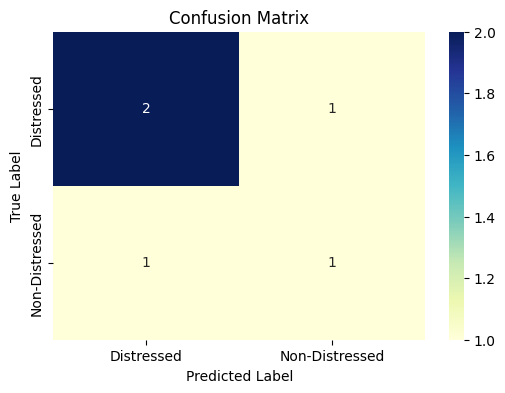

In [3]:
# Model Evaluation
def evaluate_model(model, X_test_embeddings, y_test_encoded):
    y_pred = model.predict(X_test_embeddings)
    print("Classification Report:\n", classification_report(y_test_encoded, y_pred))

    cm = confusion_matrix(y_test_encoded, y_pred)
    plot_confusion_matrix(cm, classes=label_encoder.classes_)

# Confusion Matrix Visualization
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", xticklabels=classes, yticklabels=classes)
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

# Model Evaluation for Logistic Regression
evaluate_model(log_reg_best_model, X_test_embeddings, y_test_encoded)



Inference

In [4]:
# Inference Function
def predict_emotion(text):
    # Preprocess and embed the input text
    text = preprocess(text)
    embedding = get_bert_embeddings([text])

    # Predict with the best model (Logistic Regression, as an example)
    log_reg_pred = log_reg_best_model.predict(embedding)[0]
    return label_encoder.inverse_transform([log_reg_pred])[0]

# Test Inference
test_texts = [
    "حاسس بضغط ومفيش فايدة",
    "أنا سعيد جدًا النهارده",
    "مش عارف أنام بسبب القلق",
    "النهارده الجو جميل ومرتاح"
]
for text in test_texts:
    print(f"Input: {text}\nPrediction: {predict_emotion(text)}\n")



Input: حاسس بضغط ومفيش فايدة
Prediction: Distressed

Input: أنا سعيد جدًا النهارده
Prediction: Non-Distressed

Input: مش عارف أنام بسبب القلق
Prediction: Distressed

Input: النهارده الجو جميل ومرتاح
Prediction: Distressed



Interface

In [5]:
!pip install gradio

In [6]:
# Gradio Interface for real-time predictions
def chatbot_interface(text):
    response = predict_emotion(text)
    return response

# Launch Gradio Interface
interface = gr.Interface(
    fn=chatbot_interface,
    inputs=gr.Textbox(lines=2, placeholder="Type your message here..."),
    outputs="text",
    title="Arabic Distress Detection Chatbot",
    description="Type a message in Arabic to check if it indicates distress or not.",
    theme="default",
)

interface.launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://423c559293e70e1b07.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
